In [75]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.stats import spearmanr
import string
import numpy as np
import gensim
import gensim.downloader as api
model = gensim.models.KeyedVectors.load_word2vec_format('glove.6B.300d.word2vec.txt', binary=False)

In [76]:
import pandas as pd

# Read the CSV file
university_data = pd.read_csv('univ.csv')

# Extract the mission statements and rankings
mission_statements = university_data['Mission'].tolist()
university_rankings = university_data['Score'].tolist()

In [77]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define custom stopwords
custom_stopwords = set(stopwords.words('english') + ['university', 'college', 'school'])

def preprocess(text):
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text.lower())

    # Remove stopwords and lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in custom_stopwords]

    # Rejoin the tokens
    text = " ".join(tokens)
    return text

preprocessed_statements = [preprocess(statement) for statement in mission_statements]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pallavit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pallavit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pallavit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pallavit/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Optimal number of topics (based on perplexity): 2


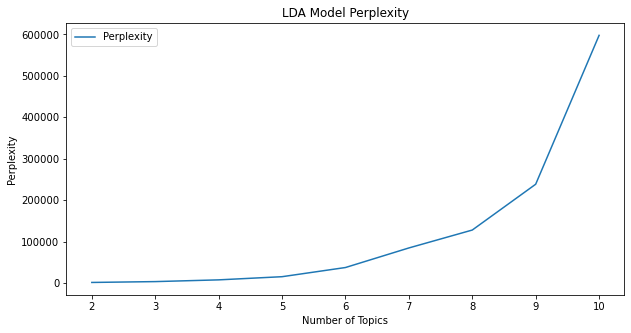

In [113]:
from sklearn.model_selection import KFold

# Perform cross-validated search for the optimal number of topics
num_topics_range = np.arange(2, 11)  # Adjust the range according to your preference
cv = KFold(n_splits=5)
perplexities = []

for num_topics in num_topics_range:
    fold_perplexities = []
    for train_indices, test_indices in cv.split(preprocessed_statements):
        train_data = [preprocessed_statements[i] for i in train_indices]
        test_data = [preprocessed_statements[i] for i in test_indices]
        
        vectorizer = CountVectorizer(stop_words='english', max_df=0.6, min_df=2)
        dtm_train = vectorizer.fit_transform(train_data)
        dtm_test = vectorizer.transform(test_data)
        
        lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda.fit(dtm_train)
        
        fold_perplexities.append(lda.perplexity(dtm_test))
    
    avg_perplexity = np.mean(fold_perplexities)
    perplexities.append(avg_perplexity)

# Find the optimal number of topics based on the lowest perplexity
optimal_num_topics = num_topics_range[np.argmin(perplexities)]
print(f"Optimal number of topics (based on perplexity): {optimal_num_topics}")

# Plot perplexity scores
plt.figure(figsize=(10, 5))
plt.plot(num_topics_range, perplexities, label="Perplexity")
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("LDA Model Perplexity")
plt.legend()
plt.show()


In [126]:
vectorizer = CountVectorizer(stop_words='english', max_df=0.6, min_df=2, ngram_range=(1, 3))
dtm = vectorizer.fit_transform(preprocessed_statements)

num_topics = 4
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

topic_distributions = lda.transform(dtm)

In [127]:
correlations = {}
for topic_idx in range(num_topics):
    correlation, p_value = spearmanr(university_rankings, topic_distributions[:, topic_idx])
    correlations[topic_idx] = {
        "correlation": correlation,
        "p_value": p_value
    }

In [128]:
for topic, values in correlations.items():
    print(f"Topic {topic}:")
    print(f"  Correlation: {values['correlation']}")
    print(f"  p-value: {values['p_value']}")

Topic 0:
  Correlation: -0.039229422162806324
  p-value: 0.8229583102221047
Topic 1:
  Correlation: -0.11320490395552683
  p-value: 0.5173129126119023
Topic 2:
  Correlation: -0.49401050909305394
  p-value: 0.002560252145810365
Topic 3:
  Correlation: -0.09877408080278022
  p-value: 0.5724026227898178


In [129]:
def embedding_vectorizer(text):
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    vectors = [model[token] for token in tokens if token in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Calculate the average word embeddings for each mission statement
dtm_embeddings = np.array([embedding_vectorizer(statement) for statement in preprocessed_statements])

# Compute the correlation between university rankings and word embeddings
correlation, p_value = spearmanr(university_rankings, dtm_embeddings)
print(f"Correlation: {correlation}")
print(f"p-value: {p_value}")

Correlation: [[ 1.         -0.17008757  0.04385289 ... -0.00658494  0.07047285
  -0.1571979 ]
 [-0.17008757  1.          0.08897296 ... -0.08953342 -0.16855822
   0.13605156]
 [ 0.04385289  0.08897296  1.         ... -0.13689225  0.21087292
  -0.22124142]
 ...
 [-0.00658494 -0.08953342 -0.13689225 ...  1.         -0.17108029
  -0.3781701 ]
 [ 0.07047285 -0.16855822  0.21087292 ... -0.17108029  1.
  -0.2332913 ]
 [-0.1571979   0.13605156 -0.22124142 ... -0.3781701  -0.2332913
   1.        ]]
p-value: [[0.         0.32864369 0.80248268 ... 0.97005241 0.68747626 0.36713901]
 [0.32864369 0.         0.61126773 ... 0.6090155  0.33307566 0.4358064 ]
 [0.80248268 0.61126773 0.         ... 0.43294889 0.22399863 0.20151611]
 ...
 [0.97005241 0.6090155  0.43294889 ... 0.         0.32578645 0.02509414]
 [0.68747626 0.33307566 0.22399863 ... 0.32578645 0.         0.17741961]
 [0.36713901 0.4358064  0.20151611 ... 0.02509414 0.17741961 0.        ]]


In [130]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
community educational excellence education impact learning make advance scholarship opportunity
Topic 1:
education engineering student new teaching university science world aim graduate
Topic 2:
community student comprehensive country culture human contributing knowledge innovative scientific
Topic 3:
education mission society student future international level knowledge excellence international level


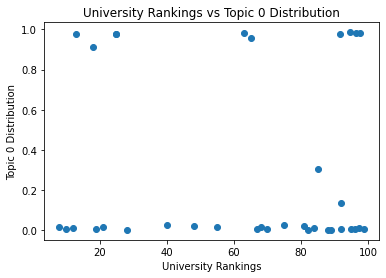

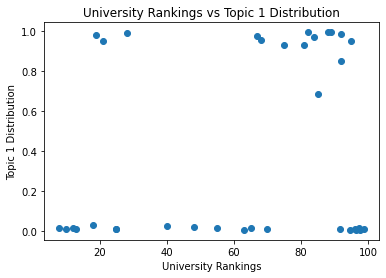

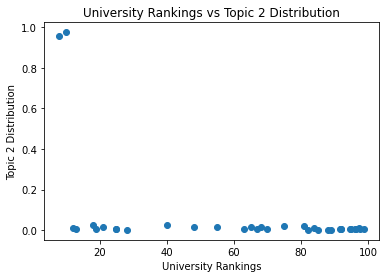

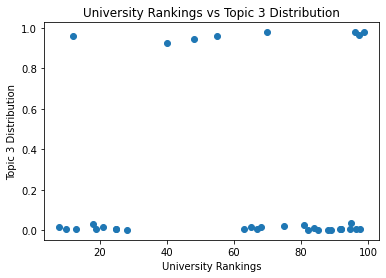

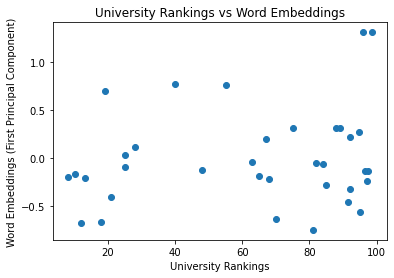

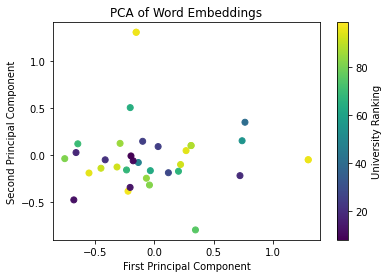

In [131]:
import matplotlib.pyplot as plt

# Scatter plot for LDA topic distributions
for topic_idx in range(num_topics):
    plt.figure()
    plt.scatter(university_rankings, topic_distributions[:, topic_idx])
    plt.xlabel("University Rankings")
    plt.ylabel(f"Topic {topic_idx} Distribution")
    plt.title(f"University Rankings vs Topic {topic_idx} Distribution")
    plt.show()

# Scatter plot for word embeddings (using the first principal component)
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
reduced_embeddings = pca.fit_transform(dtm_embeddings)

plt.figure()
plt.scatter(university_rankings, reduced_embeddings)
plt.xlabel("University Rankings")
plt.ylabel("Word Embeddings (First Principal Component)")
plt.title("University Rankings vs Word Embeddings")
plt.show()

# Extract the word embeddings and university rankings
embeddings = dtm_embeddings[:, :-1]

# Perform PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Create a scatter plot of the reduced embeddings
plt.figure()
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=university_rankings, cmap='viridis')
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA of Word Embeddings")
plt.colorbar(label="University Ranking")
plt.show()

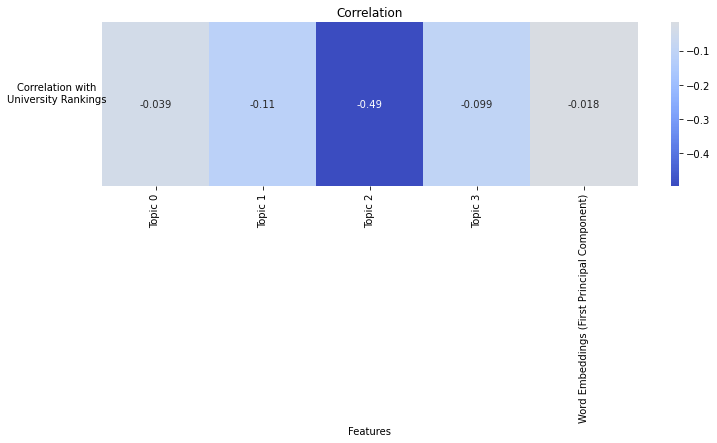

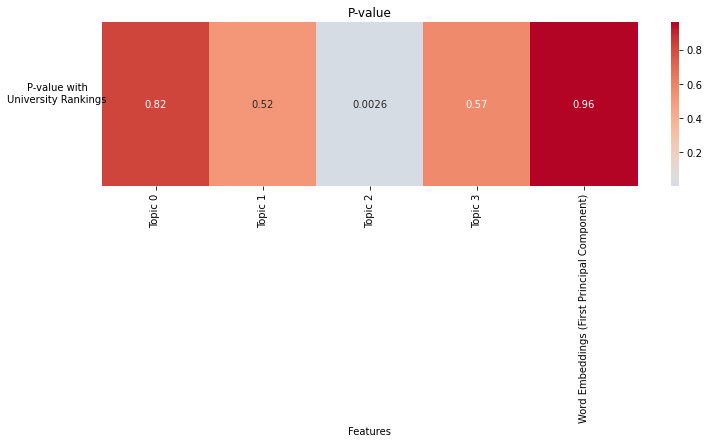

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine correlation and p-value for LDA topics and word embeddings
combined_correlation = [correlations[topic]["correlation"] for topic in range(num_topics)] + [correlation_embeddings]
combined_p_value = [correlations[topic]["p_value"] for topic in range(num_topics)] + [p_value_embeddings]

# Feature labels
lda_labels = [f"Topic {topic}" for topic in range(num_topics)]
embedding_labels = ["Word Embeddings (First Principal Component)"]
feature_labels = lda_labels + embedding_labels

# Heatmap for the correlation
plt.figure(figsize=(12, 3))
sns.heatmap([combined_correlation], annot=True, cmap="coolwarm", center=0, xticklabels=feature_labels, yticklabels=False)
plt.xlabel("Features")
plt.ylabel("Correlation with\nUniversity Rankings", rotation=0, labelpad=45)
plt.title("Correlation")
plt.show()

# Heatmap for the p-value
plt.figure(figsize=(12, 3))
sns.heatmap([combined_p_value], annot=True, cmap="coolwarm", center=0.05, xticklabels=feature_labels, yticklabels=False)
plt.xlabel("Features")
plt.ylabel("P-value with\nUniversity Rankings", rotation=0, labelpad=45)
plt.title("P-value")
plt.show()


In [97]:
# import pandas as pd

# # Create a DataFrame with the average word embeddings
# embeddings_df = pd.DataFrame(dtm_embeddings)

# # Add a column with the university rankings
# embeddings_df['University Ranking'] = university_rankings

# # Display the DataFrame
# # print(embeddings_df)

num_dimensions = 300
correlations = []

for dim in range(num_dimensions):
    correlation, p_value = spearmanr(university_rankings, dtm_embeddings)
    correlations.append({
        'Dimension': dim,
        'Correlation': correlation,
        'p_value': p_value
    })

correlations_df = pd.DataFrame(correlations)
print(correlations_df)

     Dimension                                        Correlation  \
0            0  [[1.0, -0.170087566091596, 0.04385288977485136...   
1            1  [[1.0, -0.170087566091596, 0.04385288977485136...   
2            2  [[1.0, -0.170087566091596, 0.04385288977485136...   
3            3  [[1.0, -0.170087566091596, 0.04385288977485136...   
4            4  [[1.0, -0.170087566091596, 0.04385288977485136...   
..         ...                                                ...   
295        295  [[1.0, -0.170087566091596, 0.04385288977485136...   
296        296  [[1.0, -0.170087566091596, 0.04385288977485136...   
297        297  [[1.0, -0.170087566091596, 0.04385288977485136...   
298        298  [[1.0, -0.170087566091596, 0.04385288977485136...   
299        299  [[1.0, -0.170087566091596, 0.04385288977485136...   

                                               p_value  
0    [[0.0, 0.3286436852683646, 0.8024826762702805,...  
1    [[0.0, 0.3286436852683646, 0.8024826762702805,...  


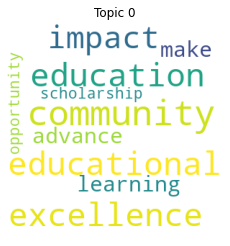

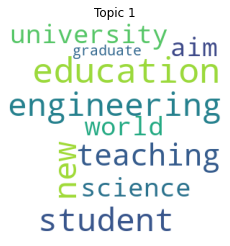

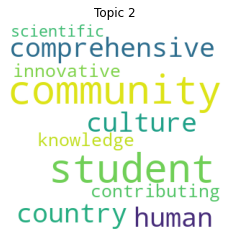

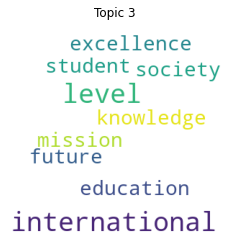

In [133]:
from wordcloud import WordCloud

def display_wordclouds(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        # Get the top words for the current topic
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]

        # Create a word cloud
        wordcloud = WordCloud(width=300, height=300, background_color='white', min_font_size=10).generate(" ".join(top_words))

        # Display the word cloud
        plt.figure(figsize=(3, 3), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.title(f"Topic {topic_idx}")
        plt.show()

no_top_words = 10
display_wordclouds(lda, vectorizer.get_feature_names_out(), no_top_words)